# Poisson-Gamma model

See Mohler et al, *Reducing Bias in Estimates for the Law of Crime Concentration* J.Quantitative Criminology, 2019 https://doi.org/10.1007/s10940-019-09404-1

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import gamma, nbinom

from spatial import (
    get_force_boundary,
    map_to_spatial_unit,
)
from utils import (
    CATEGORIES,
    extract_crime_data,
)

In [ ]:
FORCE = "West Yorkshire"
rng = np.random.default_rng(19937)

force_boundary = get_force_boundary(FORCE)

CATEGORY = CATEGORIES[1]
raw_crime_data = extract_crime_data(FORCE)
# filter by category and remove any points
raw_crime_data = raw_crime_data[(raw_crime_data["Crime type"] == CATEGORY)]
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


In [4]:
crime_data, spatial_units = map_to_spatial_unit(raw_crime_data, force_boundary, "LSOA")

In [5]:
# ensure we account for crime-free LSOAs in the data
counts = (
    crime_data.groupby(["Month", "LSOA code"])["Crime type"].count().unstack(level="Month", fill_value=0).sort_index()
)
counts

Month,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,...,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04
LSOA code,,,,,,,,,,,,,,,,,,,,,
E01005410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E01005414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
E01005561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E01007319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
E01007328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E01035050,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,0,1,1,0,3,2
E01035051,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
E01035052,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,1,0,0,0,2,1


In [6]:
def nbinom_fit(sample: pd.Series):
    sample.name = "nbdata"
    # Dispersion parameter from nb model with only interaction term
    nbfit = smf.negativebinomial("nbdata ~ 1", data=sample.to_frame()).fit()
    mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
    alpha = nbfit.params[1]  # Dispersion parameter
    var = mu + alpha * mu**2
    p = mu / var
    n = mu**2 / (var - mu)
    return pd.Series({"n": n, "p": p})

In [7]:
model_params = counts.apply(nbinom_fit).T
model_params

Optimization terminated successfully.
         Current function value: 1.729255
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.835550
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.970278
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.985134
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.752960
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.759075
         Iterations: 5
         Function evaluations: 6
         Gradient e

/tmp/ipykernel_177288/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_177288/2054698704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_177288/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_177288/2054698

,n,p
Month,,
2022-05,0.860168,0.350030
2022-06,0.944264,0.341001
2022-07,0.928827,0.301109
2022-08,0.913139,0.293708
2022-09,0.761467,0.315003
2022-10,0.749998,0.309873
2022-11,0.678801,0.345081
2022-12,0.530976,0.400390
2023-01,0.661263,0.389796


<Axes: xlabel='Month'>

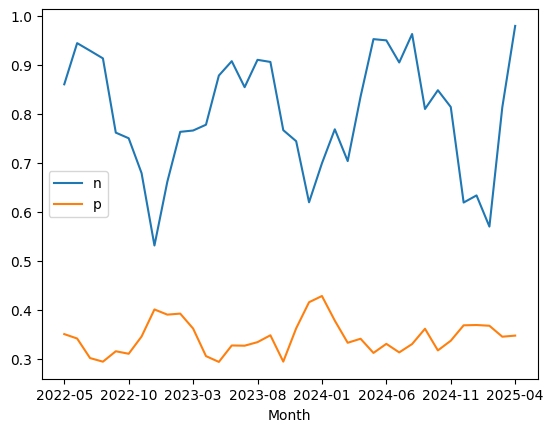

In [8]:
model_params.plot()

<Axes: xlabel='Month'>

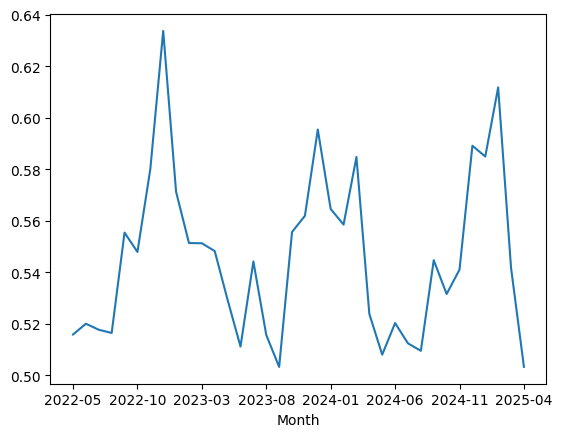

In [9]:
# Seasonality of **crime concentration**

# translated from Appendix in Mohler (2019)
samples = len(counts)
threshold = int(0.1 * samples)


def calc_gini(model_params: pd.Series):
    # simulated_gam=rgamma(Ntotal, shape=pars[1], rate=1)
    # scipy.stats.gamma uses shape (a) and scale (1/rate)
    # descending order by virtue of sorting on a reversed *view* of the array

    # this is sampled lambda??
    gamma_sample = np.sort(gamma.rvs(a=model_params["n"], scale=1, size=samples, random_state=rng))[::-1]

    # but the mean of Poisson(lamdba) == lambda, so we can use

    # concentration=sum(sorted_gam[1:Nflag])/sum(sorted_gam)
    # Python slicing is 0-based and exclusive of the end index.
    # R's 1:Nflag corresponds to indices 0 to Nflag-1 in Python, which is [:Nflag]
    _concentration = np.sum(gamma_sample[:threshold]) / np.sum(gamma_sample)
    # print(f"Concentration (simulated): {concentration:.4f}")
    # # normalized_gam=sorted_gam/sum(sorted_gam)
    gamma_norm = gamma_sample / np.sum(gamma_sample)

    # # gini=(1/Ntotal)*(2*sum(cumsum(normalized_gam))-Ntotal-1)
    gini = (1.0 / samples) * (2 * np.sum(np.cumsum(gamma_norm)) - samples - 1)
    return gini


gini = model_params.apply(calc_gini, axis=1)
gini.name = "gini"
gini.plot()

In [10]:
# sample and compare fits
n = model_params.n.mean()
p = model_params.p.mean()
sample = pd.Series(nbinom(n, p).rvs(size=100000, random_state=rng))

(nbinom_fit(sample) / np.array([n, p]) - 1.0).rename("diff")

Optimization terminated successfully.
         Current function value: 1.685950
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


/tmp/ipykernel_177288/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_177288/2054698704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter


n    0.010620
p    0.012782
Name: diff, dtype: float64

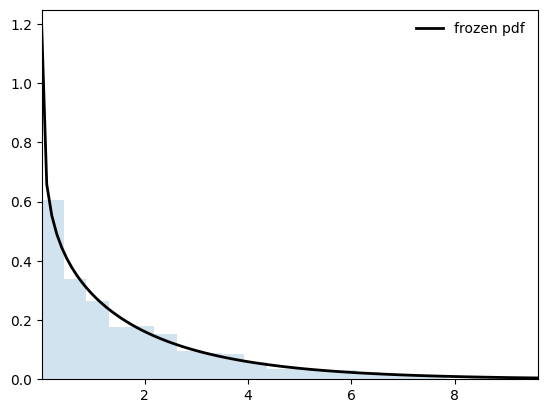

In [11]:
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

t = 1  # ? not sure about this
beta = n * t / p

_, ax = plt.subplots()
dist = gamma(a=n, scale=beta)  # or might be 1 / beta?

x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
ax.plot(x, dist.pdf(x), "k-", lw=2, label="frozen pdf")

# Check accuracy of cdf and ppf:
vals = dist.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], dist.cdf(vals))

# Generate random numbers:
r = dist.rvs(size=1000, random_state=rng)

# And compare the histogram:
ax.hist(r, density=True, bins="auto", histtype="stepfilled", alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc="best", frameon=False)
plt.show()

In [13]:
# sample the lambdas for each area
lambda_ = dist.rvs(size=len(counts), random_state=rng)

sim = pd.Series(rng.poisson(lambda_))
# re-fit negative binomial - why is p consistently underestimated???
nbinom_fit(sim), n, p

Optimization terminated successfully.
         Current function value: 1.846770
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


/tmp/ipykernel_177288/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_177288/2054698704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter


(n    0.786764
 p    0.297100
 dtype: float64,
 np.float64(0.7995069626892255),
 np.float64(0.3437389135183604))

In [14]:
sim = counts.copy()
n_areas = len(sim)
t = 1  # ? not sure about this

for col in sim:
    n, p = model_params.loc[col]
    beta = n * t / p
    lambda_ = gamma.rvs(a=n, scale=beta, size=n_areas)
    sim[col] = rng.poisson(lambda_)

# forcing scale to around 1.95 lines these up
counts.mean().mean(), sim.mean().mean()

(np.float64(1.5671455938697316), np.float64(1.9516858237547892))

In [15]:
counts.sum().sum(), sim.sum().sum()

(np.int64(81805), np.int64(101878))